# Week 1 Pair Scan Workflow
This notebook walks through the full Track A analytics flow: load the configured ETF universe, compute correlation diagnostics, score candidate pairs (Engle–Granger), and persist artifacts (CSV/figures) for advisor reporting.

In [2]:
from pathlib import Path
from matplotlib import pyplot as plt
import sys

project_root = Path.cwd()
while not (project_root / "src").exists() and project_root != project_root.parent:
    project_root = project_root.parent

src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

In [3]:
import importlib
import inspect
from dataclasses import replace

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import pairs_trading_etf.analysis.correlation as correlation_module
import pairs_trading_etf.visualization.plots as plots_module
from pairs_trading_etf.analysis.correlation import (
    attach_sector_labels,
    compute_return_correlations,
    find_high_corr_pairs,
    summarise_pairs_by_bucket,
)
from pairs_trading_etf.visualization.plots import (
    plot_corr_vs_pvalue,
    plot_correlation_clustermap,
    plot_correlation_heatmap,
    plot_pair_bucket_boxplot,
    plot_pair_bucket_counts,
)
from pairs_trading_etf.data.loader import build_price_frame
from pairs_trading_etf.data.universe import load_configured_universe
from pairs_trading_etf.pipelines.pair_scan import PairScanConfig, run_pair_scan
from pairs_trading_etf.utils.config import load_yaml_config

correlation_module = importlib.reload(correlation_module)
plots_module = importlib.reload(plots_module)

sns.set_theme(style="white", context="talk")

CONFIG_PATH = project_root / "configs" / "data.yaml"
PRICE_PATH = project_root / "data" / "raw" / "etf_prices.csv"
METADATA_PATH = project_root / "configs" / "etf_metadata.yaml"
RESULTS_PATH = project_root / "results" / "week1_pair_scores.csv"
FIGURES_DIR = project_root / "results" / "figures" / "week1"
JOHANSEN_PATH = project_root / "results" / "week1_johansen_trace.csv"
HEATMAP_PATH = FIGURES_DIR / "week1_corr_heatmap.png"
CLUSTER_PATH = FIGURES_DIR / "week1_corr_clustermap.png"
PAIR_COUNTS_PATH = FIGURES_DIR / "week1_pair_bucket_counts.png"
PAIR_BOX_PATH = FIGURES_DIR / "week1_pair_corr_box.png"
SCATTER_PATH = FIGURES_DIR / "week1_corr_vs_pvalue.png"
HIGH_CORR_PATH = project_root / "results" / "week1_high_corr_pairs.csv"

CONFIG_PATH, PRICE_PATH, METADATA_PATH, RESULTS_PATH, FIGURES_DIR, JOHANSEN_PATH

(WindowsPath('i:/Winter-Break-Research/configs/data.yaml'),
 WindowsPath('i:/Winter-Break-Research/data/raw/etf_prices.csv'),
 WindowsPath('i:/Winter-Break-Research/configs/etf_metadata.yaml'),
 WindowsPath('i:/Winter-Break-Research/results/week1_pair_scores.csv'),
 WindowsPath('i:/Winter-Break-Research/results/figures/week1'),
 WindowsPath('i:/Winter-Break-Research/results/week1_johansen_trace.csv'))

In [4]:
config = load_yaml_config(CONFIG_PATH)
pair_defaults = config.get("pair_scan", {})

# Quick toggles: set either flag to override the YAML values without editing the file
FORCE_FULL_UNIVERSE = pair_defaults.get("force_full_universe", False)
FORCE_CROSS_SECTOR = pair_defaults.get("force_cross_sector", True)

LIST_OVERRIDE = pair_defaults.get("list_name")
if pair_defaults.get("use_full_universe") or FORCE_FULL_UNIVERSE:
    LIST_OVERRIDE = None

universe_cfg = config.get("universe", {})
universe_lists = universe_cfg.get("lists") or {}
TOTAL_DEFINED_TICKERS = len(universe_cfg.get("etfs", []))

if isinstance(LIST_OVERRIDE, str) and LIST_OVERRIDE.lower() in {"all", "full", "extended_all"}:
    LIST_OVERRIDE = None

resolved_label = (
    f"list '{LIST_OVERRIDE}'"
    if LIST_OVERRIDE
    else f"full `universe.etfs` roster ({TOTAL_DEFINED_TICKERS} tickers)"
 )
print(f"Resolved pair-scan list target: {resolved_label}")
if LIST_OVERRIDE and LIST_OVERRIDE in universe_lists:
    list_len = len(universe_lists[LIST_OVERRIDE].get("tickers", []))
    if TOTAL_DEFINED_TICKERS and list_len < TOTAL_DEFINED_TICKERS:
        print(
            f"Note: list '{LIST_OVERRIDE}' uses {list_len} of {TOTAL_DEFINED_TICKERS} tickers defined in universe.etfs.",
        )

ALLOW_CROSS_SECTOR = pair_defaults.get("allow_cross_sector", True)
if FORCE_CROSS_SECTOR:
    ALLOW_CROSS_SECTOR = True
print(f"Cross-sector pairs allowed? {ALLOW_CROSS_SECTOR} (force flag={FORCE_CROSS_SECTOR})")

print("Loaded pair scan defaults:")
pair_defaults

Resolved pair-scan list target: full `universe.etfs` roster (50 tickers)
Cross-sector pairs allowed? True (force flag=True)
Loaded pair scan defaults:


{'list_name': 'core_sectors',
 'use_full_universe': True,
 'allow_cross_sector': True,
 'lookback_days': 252,
 'min_obs': 180,
 'min_corr': 0.8,
 'max_pairs': None,
 'engle_granger_maxlag': 1,
 'return_method': 'log',
 'use_log': True}

In [5]:
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.parent.mkdir(parents=True, exist_ok=True)
print(f"Artifacts will be written to {RESULTS_PATH.parent}")

Artifacts will be written to i:\Winter-Break-Research\results


In [6]:
universe = load_configured_universe(
    CONFIG_PATH,
    list_name=LIST_OVERRIDE,
    metadata_path=METADATA_PATH,
 )
list_label = LIST_OVERRIDE or "universe.etfs"
print(f"Universe '{universe.name}' ({list_label}) with {len(universe.tickers)} tickers")
if TOTAL_DEFINED_TICKERS and len(universe.tickers) < TOTAL_DEFINED_TICKERS and LIST_OVERRIDE:
    print(
        f"Reminder: {len(universe.tickers)} tickers selected while {TOTAL_DEFINED_TICKERS} are available in universe.etfs.",
    )

metadata_records = []
if universe.metadata:
    for ticker, meta in universe.metadata.items():
        metadata_records.append(
            {
                "ticker": ticker,
                "name": meta.name,
                "sector": meta.sector,
                "issuer": meta.issuer,
                "expense_ratio": meta.expense_ratio,
            }
        )

metadata_df = (
    pd.DataFrame(metadata_records).set_index("ticker").sort_index()
    if metadata_records
    else pd.DataFrame()
 )
metadata_df.head(10)

Universe 'core_sectors' (universe.etfs) with 50 tickers


,name,sector,issuer,expense_ratio
ticker,,,,
AGG,iShares Core U.S. Aggregate Bond ETF,Fixed Income,BlackRock,0.03
BND,Vanguard Total Bond Market ETF,Fixed Income,Vanguard,0.03
DIA,SPDR Dow Jones Industrial Average ETF Trust,Broad Market,State Street Global Advisors,0.16
EEM,iShares MSCI Emerging Markets ETF,Broad Market,BlackRock,0.69
EFA,iShares MSCI EAFE ETF,Broad Market,BlackRock,0.33
EWJ,iShares MSCI Japan ETF,International,BlackRock,0.50
EWW,iShares MSCI Mexico ETF,International,BlackRock,0.50
FXI,iShares China Large-Cap ETF,International,BlackRock,0.74
HYG,iShares iBoxx $ High Yield Corporate Bond ETF,Fixed Income,BlackRock,0.48


In [7]:
build_kwargs = {
    "price_path": PRICE_PATH,
    "tickers": universe.tickers,
    "min_non_na": pair_defaults.get("min_obs", 150),
    "return_method": pair_defaults.get("return_method", "log"),
}

if "allow_missing" in inspect.signature(build_price_frame).parameters:
    build_kwargs["allow_missing"] = True

default_price_frame = build_price_frame(**build_kwargs)
price_frame = default_price_frame
print(
    f"Price frame has {price_frame.prices.shape[0]} rows x {price_frame.prices.shape[1]} tickers"
)
price_frame.prices.tail()

Price frame has 2768 rows x 50 tickers


,XLK,IYW,XLF,VFH,XLE,XLY,XLV,XLI,XLP,XLB,...,SPLV,VEA,VWO,VGK,EWJ,FXI,EWW,ILF,AGG,BND
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,239.403473,165.136459,48.486374,118.527473,82.602394,232.919464,137.494888,132.794693,77.948151,84.292786,...,69.431557,47.215443,44.365299,62.573887,65.916412,30.657393,47.551369,20.683287,93.667496,69.566383
2024-12-26,239.562714,165.196365,48.605137,118.774696,82.534073,232.055237,137.771210,132.893661,78.193459,84.164665,...,69.470833,47.402184,44.256290,62.740307,66.680229,30.686975,47.561188,20.644205,93.735252,69.614807
2024-12-27,236.377701,162.739716,48.248840,117.944031,82.524315,228.220749,137.129730,131.903824,77.810791,83.711327,...,69.146805,47.284245,44.097740,62.534733,67.186142,30.420732,47.138817,20.517195,93.541656,69.469566
2024-12-30,233.371857,160.782349,47.783669,116.737602,82.514557,224.555145,135.442123,130.577469,76.898247,82.587814,...,68.577286,46.989391,43.711266,62.123577,66.620720,30.065741,45.861874,20.478113,93.909462,69.740669
2024-12-31,231.430969,159.304367,47.833160,116.757378,83.597839,222.866394,135.767822,130.419098,77.133743,82.922890,...,68.734413,46.999218,43.641895,62.133366,66.561195,30.016438,45.989567,20.429264,93.793320,69.624489


In [8]:
MIN_OBS_REQUIRED = pair_defaults.get("min_obs", 150)
coverage_df = (
    price_frame.prices.notna().sum().to_frame("observations")
    .assign(
        coverage_pct=lambda df: (
            df["observations"] / price_frame.prices.shape[0] * 100
        ).round(2),
        meets_min_obs=lambda df: df["observations"] >= MIN_OBS_REQUIRED,
    )
    .sort_values("coverage_pct")
 )
print(
    f"Median coverage: {coverage_df['coverage_pct'].median():.1f}% | "
    f"Tickers meeting min_obs ({MIN_OBS_REQUIRED}): {coverage_df['meets_min_obs'].sum()} / {len(coverage_df)}"
)
low_coverage = coverage_df[~coverage_df["meets_min_obs"]]
if low_coverage.empty:
    display(coverage_df.tail(10))
else:
    print("Tickers below min_obs; consider dro  pping or lowering min_obs:")
    display(low_coverage)

Median coverage: 100.0% | Tickers meeting min_obs (180): 50 / 50


,observations,coverage_pct,meets_min_obs
SPLV,2768,100.0,True
VEA,2768,100.0,True
VWO,2768,100.0,True
VGK,2768,100.0,True
EWJ,2768,100.0,True
FXI,2768,100.0,True
EWW,2768,100.0,True
ILF,2768,100.0,True
AGG,2768,100.0,True
BND,2768,100.0,True


## Correlation Diagnostics
Convert prices to returns (log/simple), build the correlation matrix, and apply sector-aware ordering for cleaner visuals.

In [9]:
# Calculate returns based on configuration
method = pair_defaults.get("return_method", "log")
prices = price_frame.prices.copy()

if method == "log":
    # Log returns: ln(P_t) - ln(P_{t-1})
    returns = np.log(prices).diff()
elif method == "simple":
    # Simple returns: (P_t - P_{t-1}) / P_{t-1}
    returns = prices.pct_change()
else:
    raise ValueError(f"Unknown return method: {method}")

# Drop the first row which will be NaN after differencing
returns = returns.dropna(how="all")

# Compute correlation matrix
corr_matrix = compute_return_correlations(returns)

print(
    f"Correlation matrix computed with shape {corr_matrix.shape[0]} x {corr_matrix.shape[1]}"
 )

# Order tickers by sector (if available) then by average correlation to keep related ETFs adjacent
if not metadata_df.empty:
    sector_info = (
        metadata_df["sector"]
        .reindex(corr_matrix.index)
        .fillna("Other")
        .to_frame(name="sector")
    )
    sector_info["avg_corr"] = corr_matrix.mean().reindex(sector_info.index)
    ordered_index = sector_info.sort_values(["sector", "avg_corr"], ascending=[True, False]).index
    corr_matrix = corr_matrix.loc[ordered_index, ordered_index]
else:
    # Fall back to ordering by average absolute correlation
    ordered_index = (
        corr_matrix.abs().mean().sort_values(ascending=False).index
    )
    corr_matrix = corr_matrix.loc[ordered_index, ordered_index]

corr_matrix.round(3).head()

Correlation matrix computed with shape 50 x 50


,VOO,SPY,IVV,IWD,SCHV,DIA,MDY,IWF,SCHG,EFA,...,XME,VNQ,XLRE,VGT,QQQ,XLK,IYW,SOXX,SMH,XLU
VOO,1.000,0.999,0.999,0.942,0.946,0.955,0.910,0.961,0.956,0.854,...,0.630,0.735,0.723,0.927,0.928,0.927,0.912,0.813,0.806,0.567
SPY,0.999,1.000,0.999,0.941,0.944,0.954,0.909,0.962,0.956,0.854,...,0.631,0.731,0.719,0.927,0.929,0.928,0.913,0.815,0.808,0.561
IVV,0.999,0.999,1.000,0.942,0.945,0.956,0.910,0.961,0.956,0.854,...,0.631,0.734,0.722,0.926,0.928,0.927,0.912,0.813,0.806,0.565
IWD,0.942,0.941,0.942,1.000,0.994,0.962,0.945,0.819,0.816,0.853,...,0.695,0.774,0.752,0.778,0.769,0.778,0.750,0.699,0.682,0.622
SCHV,0.946,0.944,0.945,0.994,1.000,0.966,0.936,0.827,0.817,0.848,...,0.677,0.774,0.755,0.787,0.778,0.789,0.759,0.708,0.691,0.636


Saved correlation heatmap to i:\Winter-Break-Research\results\figures\week1\week1_corr_heatmap.png


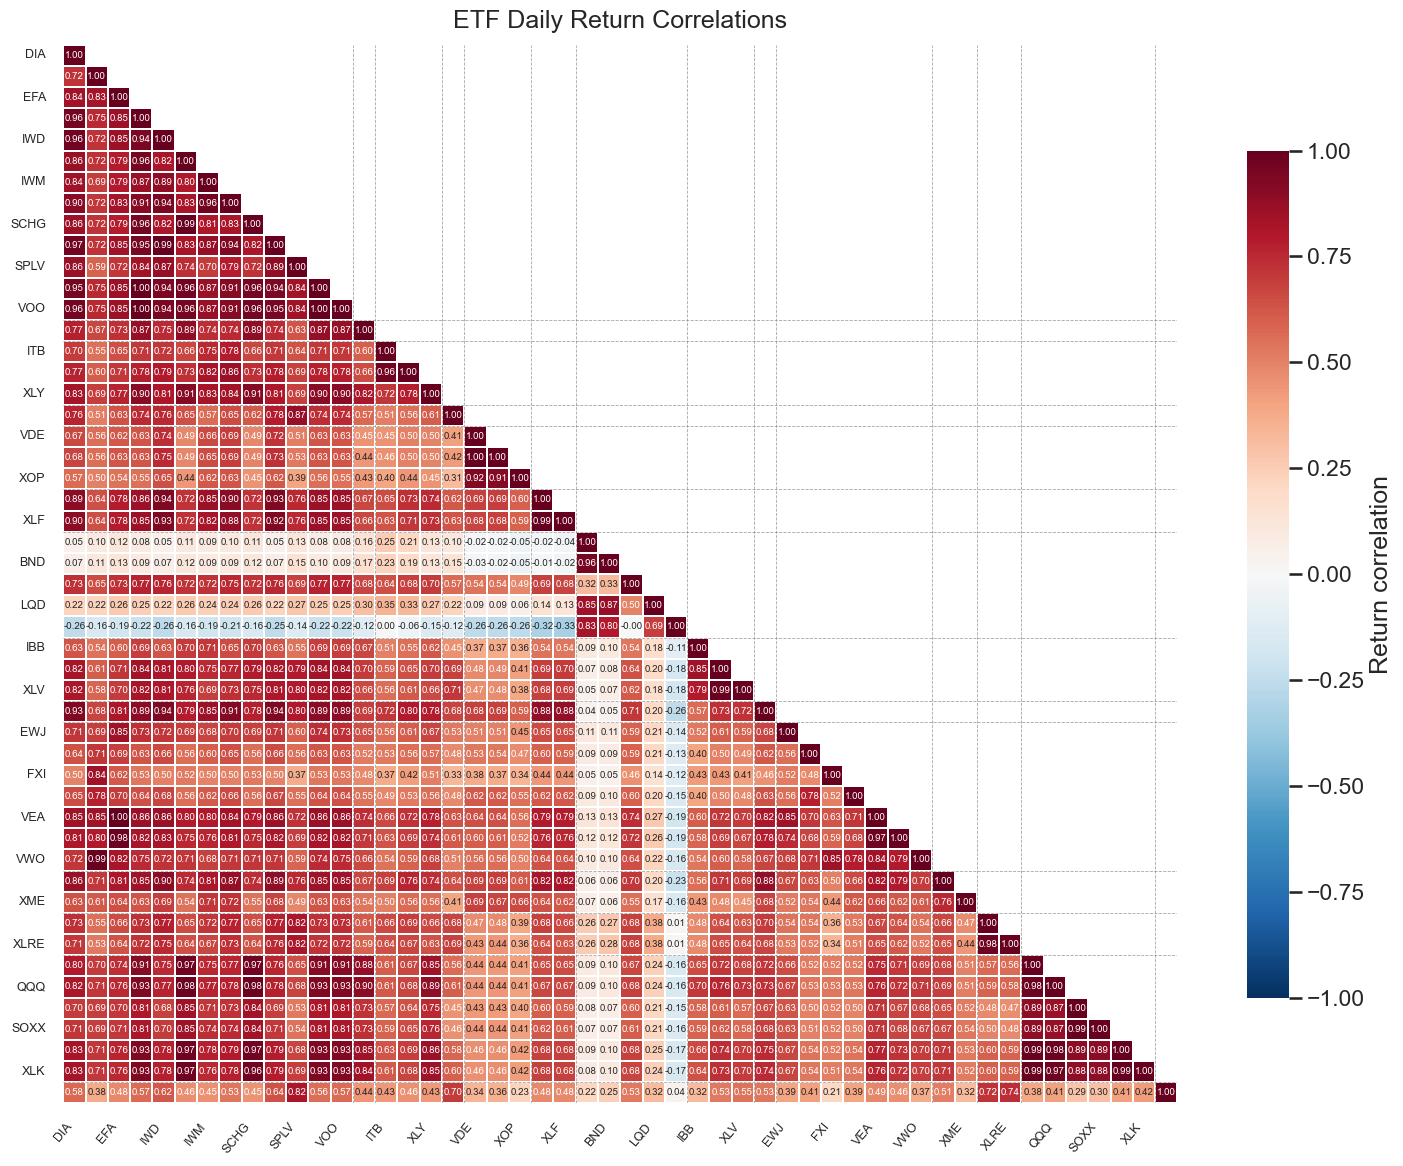

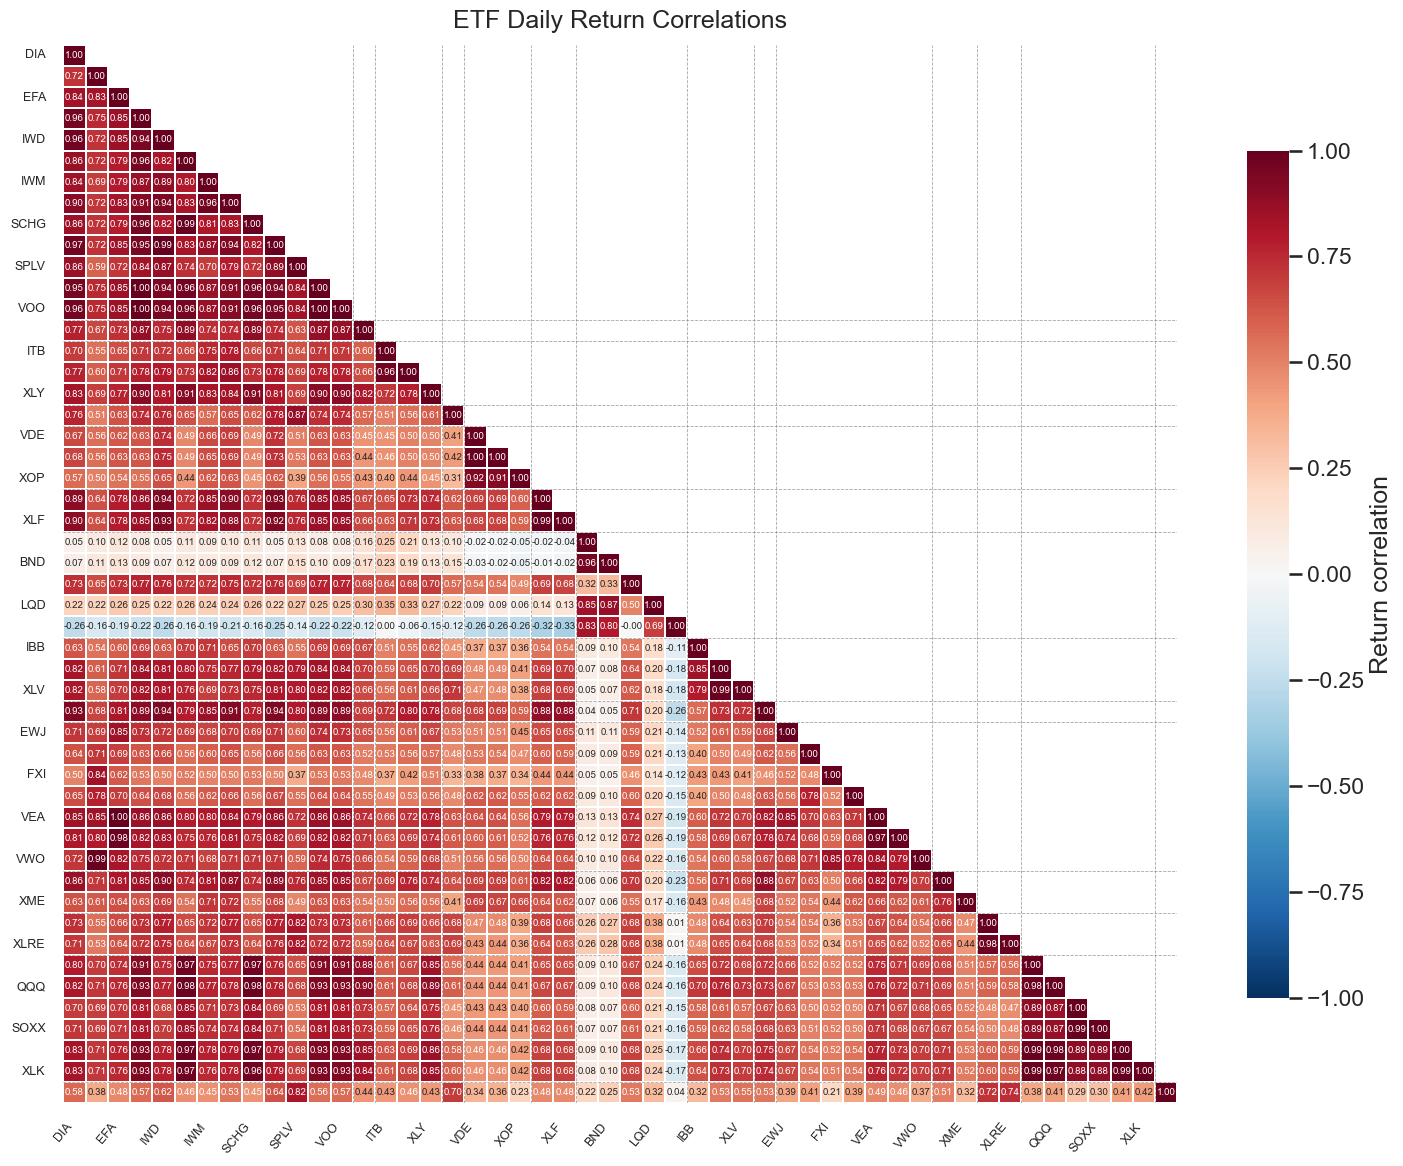

In [10]:
heatmap_fig = plot_correlation_heatmap(
    corr_matrix,
    lower_triangle=True,
    mask_diagonal=False,
    annot=True,
    figsize=(15, 12),
    output_path=HEATMAP_PATH,
    cmap="RdBu_r",
    metadata=metadata_df,
)
print(f"Saved correlation heatmap to {HEATMAP_PATH}")
heatmap_fig


Saved clustermap to i:\Winter-Break-Research\results\figures\week1\week1_corr_clustermap.png


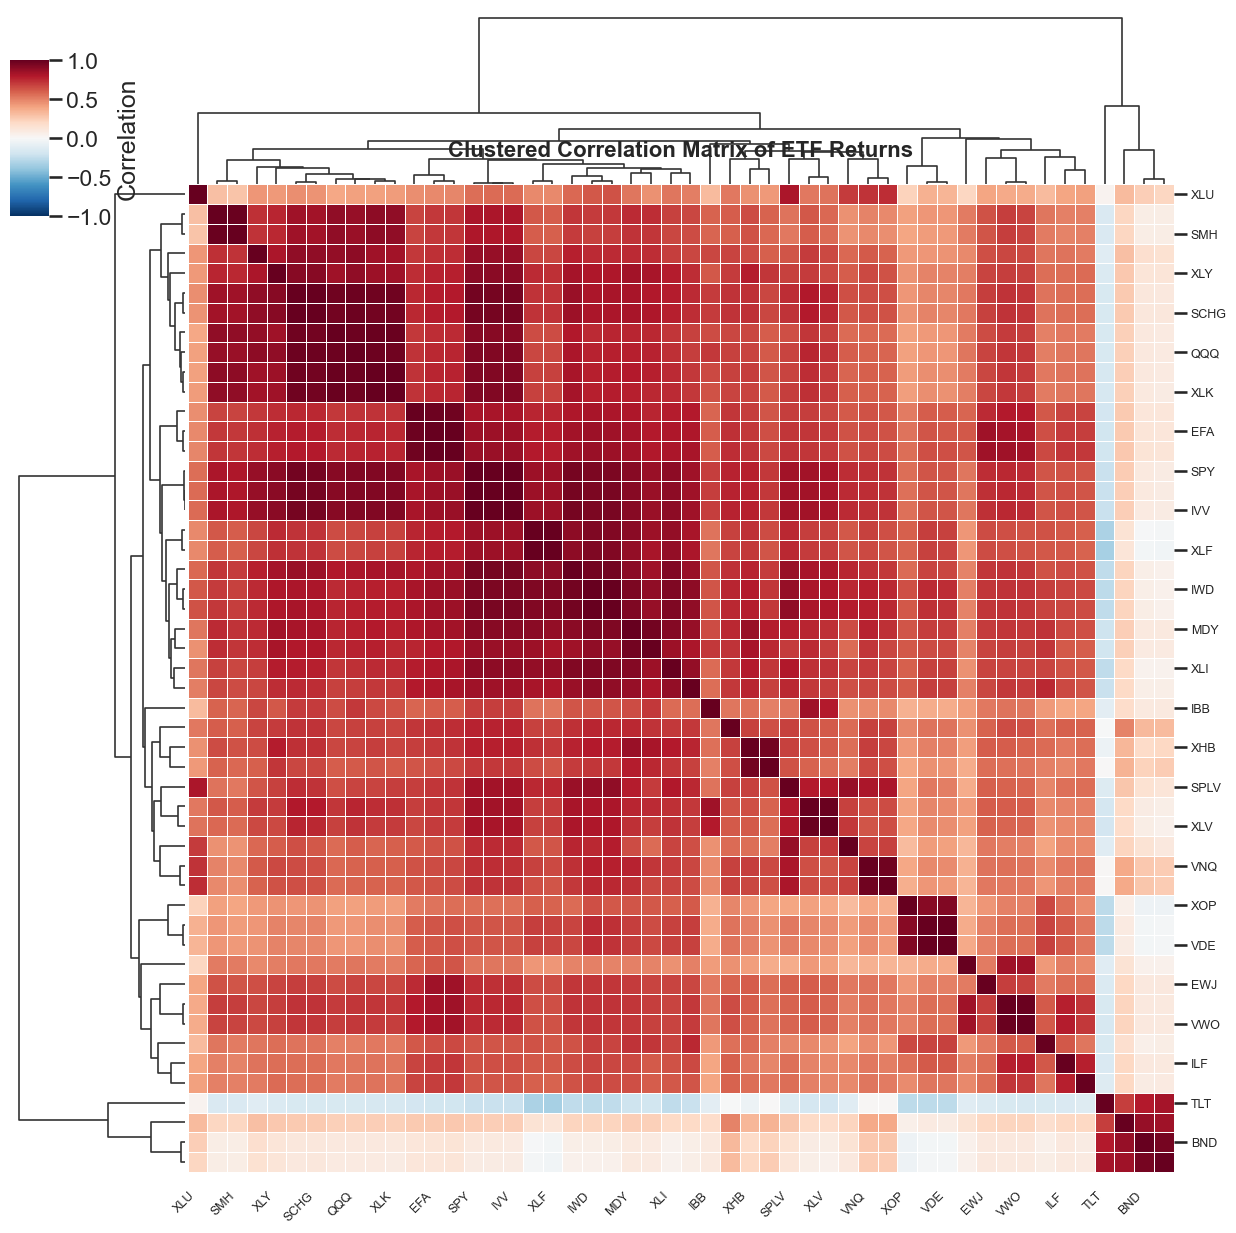

In [11]:
cluster_grid = plot_correlation_clustermap(
    corr_matrix,
    output_path=CLUSTER_PATH,
)
print(f"Saved clustermap to {CLUSTER_PATH}")
cluster_grid


## High-Correlation Pair Search
Iteratively back off the minimum correlation threshold until we surface at least one qualifying pair and persist the ranked table.

In [12]:
base_corr_threshold = pair_defaults.get("min_corr", 0.85)
backoff_steps = (0.0, 0.02, 0.05, 0.08, 0.12, 0.15)
corr_trials = []
high_corr_pairs = pd.DataFrame()
selected_threshold = None

for step in backoff_steps:
    trial_threshold = round(max(base_corr_threshold - step, 0.7), 3)
    if corr_trials and abs(trial_threshold - corr_trials[-1]["threshold"]) < 1e-6:
        continue
    trial_df = find_high_corr_pairs(corr_matrix, threshold=trial_threshold)
    corr_trials.append({"threshold": trial_threshold, "pair_count": len(trial_df)})
    if not trial_df.empty:
        high_corr_pairs = trial_df.assign(corr_threshold_used=trial_threshold)
        selected_threshold = trial_threshold
        break

attempt_log = pd.DataFrame(corr_trials)
print("High-correlation pair search attempts:")
display(attempt_log)

if high_corr_pairs.empty:
    print(
        "No correlation pairs cleared the adaptive thresholds; consider expanding the lookback window or lowering min_corr further.",
    )
else:
    metadata_source = metadata_df if not metadata_df.empty else (universe.metadata or {})
    high_corr_pairs = attach_sector_labels(high_corr_pairs, metadata_source)
    high_corr_pairs.to_csv(HIGH_CORR_PATH, index=False)
    print(
        f"Full high-correlation pair table saved to {HIGH_CORR_PATH} using threshold {selected_threshold:.2f}",
    )
    display(high_corr_pairs.sort_values("correlation", ascending=False).head(10))

High-correlation pair search attempts:


,threshold,pair_count
0,0.8,231


Full high-correlation pair table saved to i:\Winter-Break-Research\results\week1_high_corr_pairs.csv using threshold 0.80


,leg_x,leg_y,correlation,pair_bucket,corr_threshold_used,sector_x,sector_y
0,VOO,IVV,0.999384,Same Sector,0.8,Broad Market,Broad Market
1,SPY,IVV,0.999165,Same Sector,0.8,Broad Market,Broad Market
2,VOO,SPY,0.999114,Same Sector,0.8,Broad Market,Broad Market
3,XLE,VDE,0.996388,Same Sector,0.8,Energy,Energy
4,EFA,VEA,0.995741,Cross Sector,0.8,Broad Market,International
5,IWF,SCHG,0.994902,Same Sector,0.8,Broad Market,Broad Market
6,IWD,SCHV,0.993844,Same Sector,0.8,Broad Market,Broad Market
7,VGT,XLK,0.993808,Same Sector,0.8,Technology,Technology
8,VFH,XLF,0.993432,Same Sector,0.8,Financials,Financials
9,VGT,IYW,0.991738,Same Sector,0.8,Technology,Technology


In [13]:
def run_pair_scan_with_backoff(
    cfg: PairScanConfig,
    *,
    corr_thresholds: list[float] | None = None,
 ) -> tuple[pd.DataFrame, list[dict[str, float]]]:
    """Run the pair scan across a list of correlation thresholds until we get results."""
    thresholds = corr_thresholds or [cfg.min_corr]
    attempt_log: list[dict[str, float]] = []
    for thr in thresholds:
        trial_cfg = replace(cfg, min_corr=thr)
        trial_df = run_pair_scan(trial_cfg)
        attempt_log.append({"min_corr": thr, "pair_count": len(trial_df)})
        if not trial_df.empty:
            trial_df = trial_df.copy()
            trial_df["min_corr_used"] = thr
            return trial_df, attempt_log
    return pd.DataFrame(), attempt_log

## Pipeline Backoff Runner
Execute the production pair-scan pipeline with adaptive correlation thresholds and persist scored pairs for Track A reporting.

In [14]:
pair_cfg_kwargs = {
    "config_path": CONFIG_PATH,
    "price_path": PRICE_PATH,
    "output_path": RESULTS_PATH,
    "list_name": LIST_OVERRIDE,
    "metadata_path": METADATA_PATH,
    "lookback_days": pair_defaults.get("lookback_days", 252),
    "min_obs": pair_defaults.get("min_obs", 150),
    "min_corr": pair_defaults.get("min_corr", 0.80),
    "max_pairs": pair_defaults.get("max_pairs"),
    "engle_granger_maxlag": pair_defaults.get("engle_granger_maxlag", 1),
    "return_method": pair_defaults.get("return_method", "log"),
}
if "allow_cross_sector" in inspect.signature(PairScanConfig).parameters:
    pair_cfg_kwargs["allow_cross_sector"] = ALLOW_CROSS_SECTOR

pair_scan_cfg = PairScanConfig(**pair_cfg_kwargs)

corr_backoff = []
for step in (0.0, 0.02, 0.04, 0.07, 0.1, 0.12, 0.15):
    candidate = round(max(pair_scan_cfg.min_corr - step, 0.7), 3)
    if not corr_backoff or candidate != corr_backoff[-1]:
        corr_backoff.append(candidate)

pair_scores, scan_attempts = run_pair_scan_with_backoff(
    pair_scan_cfg, corr_thresholds=corr_backoff
)
print("Pair-scan attempts by min_corr:")
display(pd.DataFrame(scan_attempts))

if pair_scores.empty:
    print("No pairs met the scan criteria even after backoff; inspect coverage stats or relax parameters further.")
else:
    pair_scores.to_csv(RESULTS_PATH, index=False)
    print(f"Scored {len(pair_scores)} pairs using min_corr >= {pair_scores['min_corr_used'].iloc[0]:.2f}.")
    print(
        f"Pair score snapshot saved to {RESULTS_PATH} (cross-sector allowed: {ALLOW_CROSS_SECTOR})",
    )
    display(pair_scores.head())

Pair-scan attempts by min_corr:


,min_corr,pair_count
0,0.8,102


Scored 102 pairs using min_corr >= 0.80.
Pair score snapshot saved to i:\Winter-Break-Research\results\week1_pair_scores.csv (cross-sector allowed: True)


,universe,leg_x,leg_y,correlation,n_obs,spread_mean,spread_std,hedge_ratio,coint_statistic,coint_pvalue,half_life,min_corr_used
0,core_sectors,VOO,IVV,0.999309,251,-0.089845,0.000210,1.000151,-15.230413,4.441675e-27,48956.189307,0.8
1,core_sectors,SPY,IVV,0.999339,251,0.018871,0.000219,0.996381,-13.843479,6.891989e-25,15002.144520,0.8
2,core_sectors,SPY,VOO,0.999356,251,0.108398,0.000195,0.996228,-12.716057,1.075342e-22,NaN,0.8
3,core_sectors,AGG,BND,0.996218,251,0.283646,0.000311,1.003389,-5.853186,3.343733e-06,NaN,0.8
4,core_sectors,QQQ,VGT,0.971172,251,0.808931,0.005759,0.843502,-3.884535,1.041760e-02,NaN,0.8


In [15]:
if pair_scores.empty:
    print("No qualifying pairs found; adjust thresholds and rerun.")
else:
    metadata_source = metadata_df if not metadata_df.empty else (universe.metadata or {})
    pair_scores = attach_sector_labels(pair_scores, metadata_source)

    corr_summary = summarise_pairs_by_bucket(pair_scores)
    display(corr_summary)
    corr_path = RESULTS_PATH.parent / "week1_pair_corr_summary.csv"
    corr_summary.to_csv(corr_path)
    print(f"Correlation summary saved to {corr_path}")

    pvalue_summary = (
        pair_scores.groupby("pair_bucket")["coint_pvalue"].agg(["mean", "median"]).round(4)
    )
    display(pvalue_summary)
    pval_path = RESULTS_PATH.parent / "week1_pair_pvalues_summary.csv"
    pvalue_summary.to_csv(pval_path)
    print(f"Engle–Granger p-value summary saved to {pval_path}")


,n_pairs,mean,min,max
pair_bucket,,,,
Cross Sector,47,0.892,0.800,0.994
Same Sector,55,0.930,0.805,0.999


Correlation summary saved to i:\Winter-Break-Research\results\week1_pair_corr_summary.csv


,mean,median
pair_bucket,,
Cross Sector,0.4091,0.2968
Same Sector,0.4144,0.3528


Engle–Granger p-value summary saved to i:\Winter-Break-Research\results\week1_pair_pvalues_summary.csv


In [16]:
COINTEGRATION_THRESHOLD = 0.05
COINTEGRATION_PATH = RESULTS_PATH.parent / "week1_cointegration_pairs.csv"
COINTEGRATION_FIG_DIR = FIGURES_DIR
COINTEGRATION_FIG_DIR.mkdir(parents=True, exist_ok=True)
cointegration_df = pd.DataFrame()

if pair_scores.empty:
    print("Skipping cointegration export because no pairs were scored.")
else:
    cointegration_df = (
        pair_scores[pair_scores["coint_pvalue"] <= COINTEGRATION_THRESHOLD]
        .sort_values("coint_pvalue")
        .reset_index(drop=True)
    )
    if cointegration_df.empty:
        print(
            f"No Engle–Granger hits below p <= {COINTEGRATION_THRESHOLD:.2f};"
            " skipping dedicated cointegration CSV."
        )
    else:
        cointegration_df.to_csv(COINTEGRATION_PATH, index=False)
        print(
            f"Exported {len(cointegration_df)} cointegrated pairs "
            f"(p <= {COINTEGRATION_THRESHOLD:.2f}) to {COINTEGRATION_PATH}."
        )

Exported 11 cointegrated pairs (p <= 0.05) to i:\Winter-Break-Research\results\week1_cointegration_pairs.csv.


Plotting top 5 cointegrated pairs by Engle–Granger p-value.
Saved spread plot to i:\Winter-Break-Research\results\figures\week1\week1_cointegration_spread_rank1_VOO_IVV.png
Saved spread plot to i:\Winter-Break-Research\results\figures\week1\week1_cointegration_spread_rank1_VOO_IVV.png


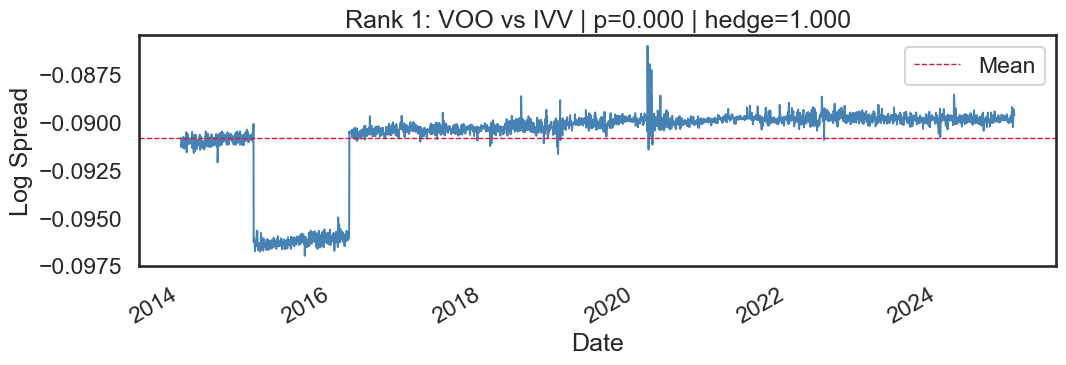

Saved spread plot to i:\Winter-Break-Research\results\figures\week1\week1_cointegration_spread_rank2_SPY_IVV.png


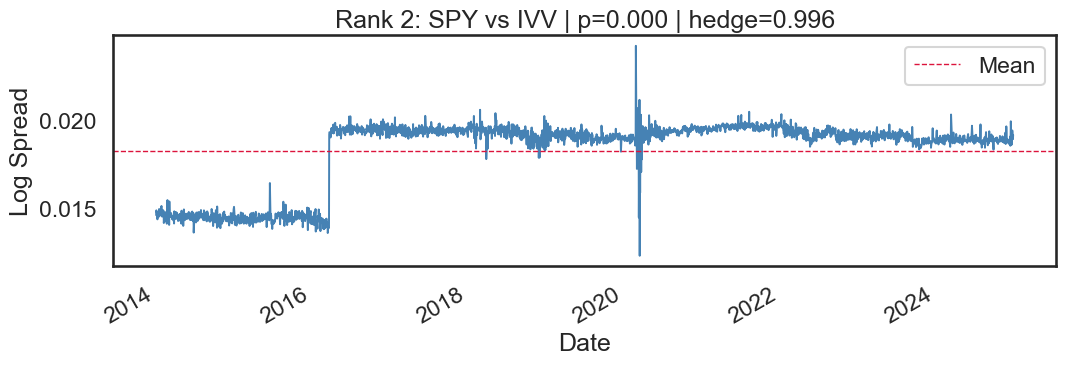

Saved spread plot to i:\Winter-Break-Research\results\figures\week1\week1_cointegration_spread_rank3_SPY_VOO.png


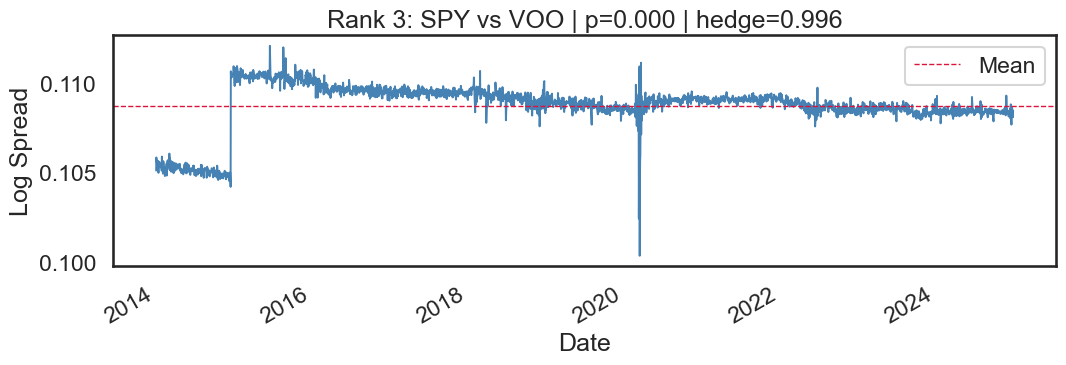

Saved spread plot to i:\Winter-Break-Research\results\figures\week1\week1_cointegration_spread_rank4_AGG_BND.png


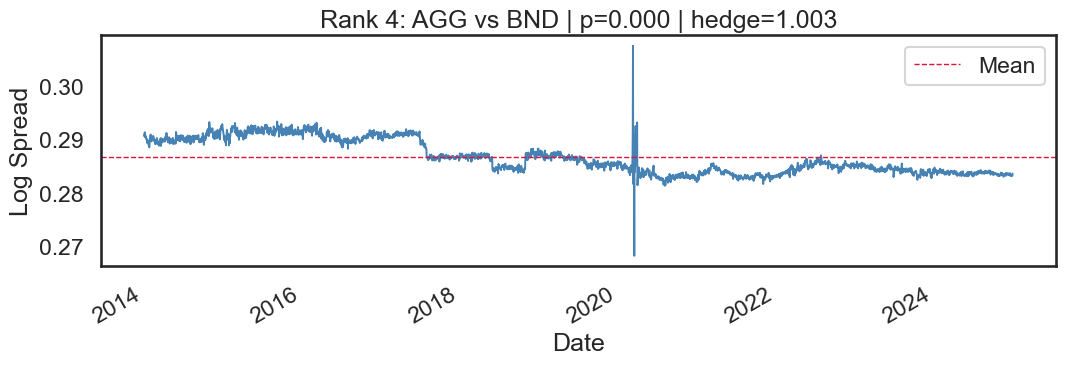

Saved spread plot to i:\Winter-Break-Research\results\figures\week1\week1_cointegration_spread_rank5_QQQ_VGT.png


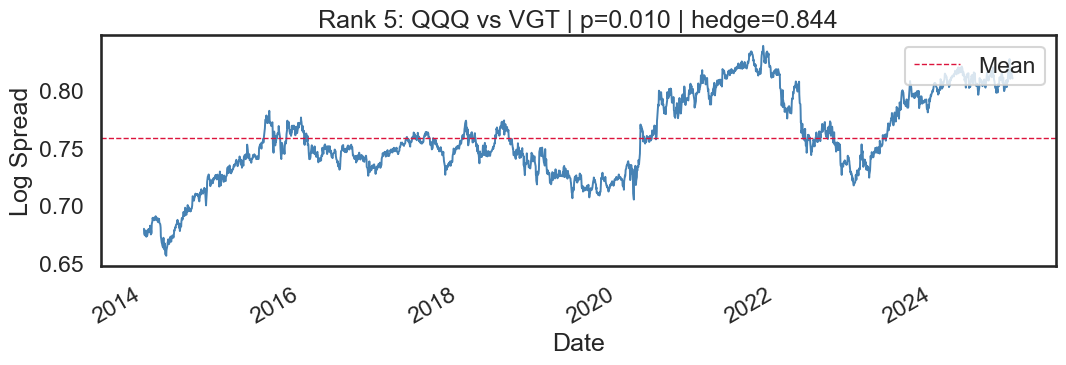

In [17]:
if cointegration_df.empty:
    print("No cointegrated pairs cleared the threshold; skipping spread plots.")
else:
    top_n = cointegration_df.head(5).copy()
    print(f"Plotting top {len(top_n)} cointegrated pairs by Engle–Granger p-value.")

    for rank, row in enumerate(top_n.itertuples(index=False), start=1):
        leg_x = row.leg_x
        leg_y = row.leg_y
        hedge_ratio = row.hedge_ratio
        legs = [leg_x, leg_y]
        available_prices = price_frame.prices[legs].dropna()
        if available_prices.empty:
            print(f"Skipping {leg_x} vs {leg_y}; no overlapping price history left.")
            continue

        # Use LOG SPREAD to match the Engle-Granger model (which uses log prices)
        log_x = np.log(available_prices[leg_x])
        log_y = np.log(available_prices[leg_y])
        spread = log_x - hedge_ratio * log_y
        
        fig, ax = plt.subplots(figsize=(11, 4))
        spread.plot(ax=ax, color="steelblue", linewidth=1.4)
        ax.axhline(spread.mean(), color="crimson", linestyle="--", linewidth=1, label="Mean")
        ax.set_title(
            f"Rank {rank}: {leg_x} vs {leg_y} | p={row.coint_pvalue:.3f} | hedge={hedge_ratio:.3f}"
        )
        ax.set_ylabel("Log Spread")
        ax.legend(loc="upper right")
        fig.tight_layout()

        safe_leg_x = leg_x.replace("/", "-")
        safe_leg_y = leg_y.replace("/", "-")
        fig_path = COINTEGRATION_FIG_DIR / (
            f"week1_cointegration_spread_rank{rank}_{safe_leg_x}_{safe_leg_y}.png"
        )
        fig.savefig(fig_path, dpi=150, bbox_inches="tight")
        print(f"Saved spread plot to {fig_path}")

        display(fig)
        plt.close(fig)

Saved count plot to i:\Winter-Break-Research\results\figures\week1\week1_pair_bucket_counts.png


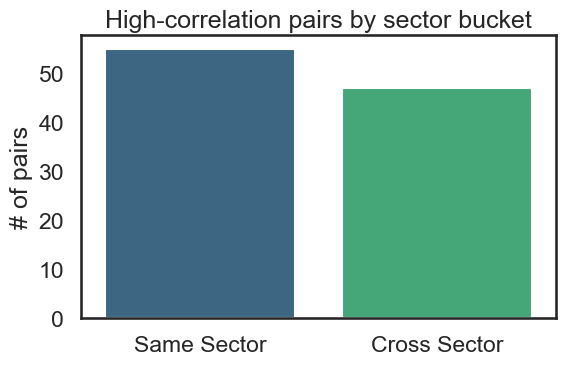

In [18]:
if pair_scores.empty:
    print("Skipping count plot because no pairs were scored.")
else:
    count_fig = plot_pair_bucket_counts(pair_scores, output_path=PAIR_COUNTS_PATH)
    print(f"Saved count plot to {PAIR_COUNTS_PATH}")
    count_fig


Saved correlation boxplot to i:\Winter-Break-Research\results\figures\week1\week1_pair_corr_box.png


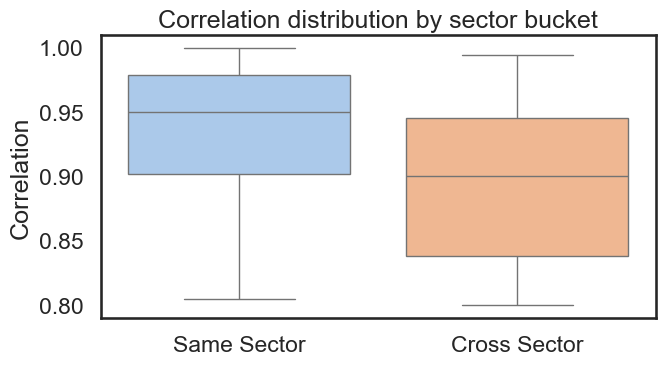

In [19]:
if pair_scores.empty:
    print("Skipping boxplot because no pairs were scored.")
else:
    box_fig = plot_pair_bucket_boxplot(pair_scores, output_path=PAIR_BOX_PATH)
    print(f"Saved correlation boxplot to {PAIR_BOX_PATH}")
    box_fig


Saved scatter plot to i:\Winter-Break-Research\results\figures\week1\week1_corr_vs_pvalue.png


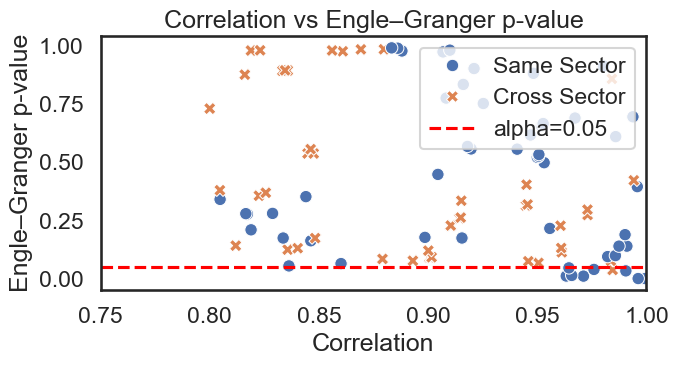

In [20]:
if pair_scores.empty:
    print("Skipping scatter plot because no pairs were scored.")
else:
    try:
        scatter_fig = plot_corr_vs_pvalue(pair_scores, output_path=SCATTER_PATH)
    except ValueError as exc:
        print(f"Skipping scatter plot: {exc}")
    else:
        print(f"Saved scatter plot to {SCATTER_PATH}")
        scatter_fig


## Johansen Confirmation
Validate the strongest trio with the Johansen trace test and archive the statistic table for Track C documentation.

In [21]:
if pair_scores.empty:
    print("Skipping Johansen test because no pairs were scored.")
else:
    top_pairs = pair_scores.sort_values("correlation", ascending=False).head(3)
    candidate = []
    for _, row in top_pairs.iterrows():
        for leg in (row["leg_x"], row["leg_y"]):
            if leg not in candidate:
                candidate.append(leg)
        if len(candidate) >= 3:
            break

    if len(candidate) < 3:
        print(
            "Need at least three unique tickers from the scored pairs to run the Johansen test."
        )
    else:
        price_frame = build_price_frame(
            PRICE_PATH, tickers=candidate, min_non_na=150, return_method="log"
        )
        levels = price_frame.prices[candidate].dropna()
        log_levels = np.log(levels.where(levels > 0)).dropna()

        johansen_res = coint_johansen(log_levels, det_order=0, k_ar_diff=1)
        trace_df = pd.DataFrame(
            {
                "trace_stat": johansen_res.lr1,
                "crit_90": johansen_res.cvt[:, 0],
                "crit_95": johansen_res.cvt[:, 1],
                "crit_99": johansen_res.cvt[:, 2],
            },
            index=[f"r <= {i}" for i in range(len(johansen_res.lr1))],
        )

        print(f"Johansen trace test for candidate set: {', '.join(candidate[:3])}")
        display(trace_df.round(3))
        trace_df.to_csv(JOHANSEN_PATH)
        print(f"Johansen trace table saved to {JOHANSEN_PATH}")

Johansen trace test for candidate set: SPY, VOO, IVV


,trace_stat,crit_90,crit_95,crit_99
r <= 0,43.809,27.067,29.796,35.463
r <= 1,14.788,13.429,15.494,19.935
r <= 2,0.083,2.706,3.842,6.635


Johansen trace table saved to i:\Winter-Break-Research\results\week1_johansen_trace.csv


## Week 1 pair-scan outputs
- `results/week1_pair_scores.csv` is overwritten on each run with the latest ranked pairs.
- `results/week1_pair_corr_summary.csv` and `results/week1_pair_pvalues_summary.csv` capture the bucketed stats for downstream reporting.
- Static figures (`results/figures/week1/*.png`) include the pair-bucket count bar, correlation boxplot, and correlation vs Engle–Granger scatter to drop into advisor decks.
- `results/week1_johansen_trace.csv` stores the Johansen trace table for the top trio, aligning with the Track C deliverables.
- Re-run the notebook whenever `configs/data.yaml` changes to regenerate all artifacts with the updated universe.